In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import learning_curve


In [72]:
data_path = "./data/lot51_vectorized.csv"
df = pd.read_csv(data_path)
df.head(5)

,name,price,brand,item_condition,shipping,located_in,return_policy,category,money_back,seller_item_sold,trending,price_boxcox,price_log
0,11,14.48,3.211678,3.382117,1.0,3.265017,1,26,1,203000.0,1,3.447473,2.739549
1,16,29.19,3.730109,3.382117,1.0,3.835941,1,73,1,49000.0,1,4.667444,3.407511
2,43,15.89,3.654544,3.382117,1.0,3.835941,1,86,1,207000.0,1,3.600318,2.826722
3,36,33.23,3.746450,4.153195,1.0,3.835941,1,187,1,49000.0,1,4.910672,3.533102
4,17,15.81,3.679971,3.867257,1.0,3.835941,1,395,1,326000.0,0,3.591949,2.821974


In [73]:
df.shape
# df["price"].max()

(31170, 13)

In [74]:
X = df.drop(['price_log', 'price', 'price_boxcox'], axis=1)
# X = df.drop(['price_log'], axis=1)
# y = df['price_boxcox']
y = df['price_boxcox'] + abs(df['price_boxcox'].min()) + 1



In [75]:
from sklearn.ensemble import AdaBoostRegressor

def calculate_cv_scores(models):
    scores = dict()
    for name, model in models:
       scores[name] = cross_val_score(model, X_train, 
            y_train, cv=5, scoring='neg_mean_squared_error') 
    return scores

X_train, X_test, y_train, y_test = train_test_split(X, y, 
            test_size=0.2, random_state=42)
model_rf = RandomForestRegressor(n_estimators = 100, 
            random_state=42)
model_gb = GradientBoostingRegressor(alpha=0.95, 
            learning_rate=0.1, loss="huber", max_depth=9, 
            max_features=0.8500000000000001, min_samples_leaf=10, 
            min_samples_split=18, n_estimators=100, 
            subsample=0.9000000000000001)
model_xg = XGBRegressor(n_estimators=100, learning_rate=0.1, 
            max_depth=5, subsample=0.8, random_state=42)
model_lr = LinearRegression()
model_ada = AdaBoostRegressor(n_estimators = 50, learning_rate = 0.001, loss = 'linear',
    random_state = 42)
models = [
    ('Random Forest', model_rf),
    ('Gradient Boosting', model_gb),
    ('XG Boost', model_xg),
    ('ADA Boost', model_ada),
]
# scores = calculate_cv_scores(models)
# for key, value in scores.items():
#     print(f'{key}: {value}')

In [76]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [80, 100, 120],
#     'learning_rate': [0.05, 0.1, 0.15],
#     'max_depth': [7, 9, 11],
#     'min_samples_split': [16, 18, 20],
#     'min_samples_leaf': [8, 10, 12],
#     'max_features': [0.75, 0.85, 0.95],
#     'subsample': [0.85, 0.9, 0.95],
# }

# grid_search = GridSearchCV(model_gb, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search.fit(X_train, y_train)

# print(f'Best parameters: {grid_search.best_params_}')
# print(f'Best score: {grid_search.best_score_}')

In [77]:
# # Get the best parameters
# best_params = grid_search.best_params_

# # Create a new model with the best parameters
# model_gb = GradientBoostingRegressor(**best_params)

# # Train the model
# model_gb.fit(X_train, y_train)

In [78]:
lambda_boxcox = 0.18301396146066823
def train_test(models):
    scores_log = dict()
    scores_actual = dict()
    actual_vs_predicted = dict()
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred = model.predict(X_test)
        y_pred = y_pred - abs(df['price_boxcox'].min()) - 1

        test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
        scores_log[name] = test_rmsle
        actual_vs_predicted[name] = list(zip(y_test[:10], y_pred[:10], (lambda_boxcox * y_test[:10] + 1) ** (1 / lambda_boxcox), (lambda_boxcox * y_pred[:10] + 1) ** (1 / lambda_boxcox)))
        # y_test_actual = np.expm1(y_test)
        y_test_actual = (lambda_boxcox * y_test + 1) ** (1 / lambda_boxcox)
        # y_pred_actual = np.expm1(y_pred)
        y_pred_actual = (lambda_boxcox * y_pred + 1) ** (1 / lambda_boxcox)
       
        test_rmsle_actual = np.sqrt(mean_squared_log_error(y_test_actual, y_pred_actual))
        scores_actual[name] = test_rmsle_actual
    return scores_log, scores_actual, actual_vs_predicted

In [79]:
log_scores, actual_scores, a = train_test(models)
df = pd.DataFrame(a["Gradient Boosting"], columns=['Actual Log', 'Predicted Log', "Actual Price", "Predicted Price"])

print("SCORING FOR BOXCOX PRICE:")
for k, v in log_scores.items():
    print(f'{k}: {v}')
print("\n")
print("SCORING FOR ACTUAL PRICE:")
for k, v in actual_scores.items():
    print(f'{k}: {v}')

print(df.head(10))

SCORING FOR BOXCOX PRICE:
Random Forest: 0.5138241591952101
Gradient Boosting: 0.5101452209532445
XG Boost: 0.50869011554337
ADA Boost: 0.5083564654657231


SCORING FOR ACTUAL PRICE:
Random Forest: 1.7631476393203585
Gradient Boosting: 1.755814011093764
XG Boost: 1.7570992410661694
ADA Boost: 1.7659423893577493
   Actual Log  Predicted Log  Actual Price  Predicted Price
0   12.019603       6.831424    575.426936        84.063448
1    7.243581       4.649348    100.658122        28.906257
2   12.068344       7.757914    584.247096       125.026479
3   10.271392       5.744129    323.587569        50.686958
4    9.205916       5.404726    220.603390        42.847651
5    6.875320       2.748468     85.716403         9.266757
6    8.595348       4.710615    174.876942        29.876125
7    9.374678       5.669916    234.830879        48.880040
8   12.001697       8.111388    572.214213       144.413743
9    8.945195       5.769740    200.013200        51.323047


In [80]:
def train_and_check_overfitting(models, X_train, y_train, X_test, y_test):
    train_scores = dict()
    test_scores = dict()
    for name, model in models:
        model.fit(X_train, y_train)
        
        y_train_pred = model.predict(X_train)
        train_rmsle = np.sqrt(mean_squared_log_error(y_train, y_train_pred))
        train_scores[name] = train_rmsle

        y_test_pred = model.predict(X_test)
        test_rmsle = np.sqrt(mean_squared_log_error(y_test, y_test_pred))
        test_scores[name] = test_rmsle

    return train_scores, test_scores

train_scores, test_scores = train_and_check_overfitting(models, X_train, y_train, X_test, y_test)

print("Train Scores:")
print(train_scores)
print("Test Scores:")
print(test_scores)


Train Scores:
{'Random Forest': 0.03909962564389208, 'Gradient Boosting': 0.07229227582506127, 'XG Boost': 0.08501435300558763, 'ADA Boost': 0.10365224726407862}
Test Scores:
{'Random Forest': 0.08752523534012938, 'Gradient Boosting': 0.08530841821082343, 'XG Boost': 0.08977778155425298, 'ADA Boost': 0.10507500466598822}


In [81]:
model_gb_simplified = GradientBoostingRegressor(alpha=0.95, learning_rate=0.1, loss="huber", max_depth=3, 
                                                max_features=0.5, min_samples_leaf=10, min_samples_split=10, 
                                                n_estimators=50, subsample=0.9, random_state=42)

# model_gb_simplified = XGBRegressor(n_estimators=100, learning_rate=0.1, 
#             max_depth=5, subsample=0.8, random_state=42)

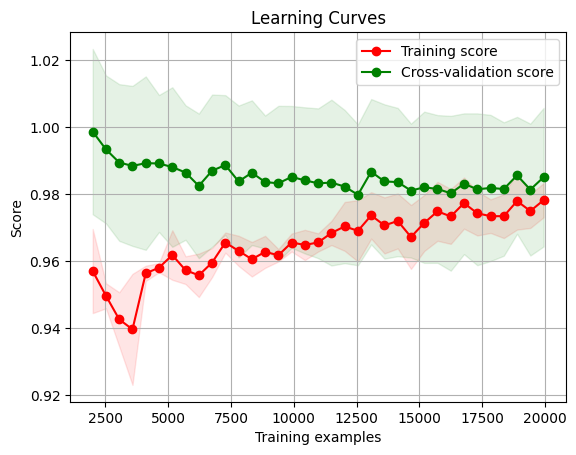

In [82]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 35))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    train_scores = np.sqrt(-train_mean)
    test_scores = np.sqrt(-test_mean)

    plt.figure()
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores - train_std, train_scores + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores - test_std, test_scores + test_std, alpha=0.1, color="g")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(model_gb_simplified, X_train, y_train)

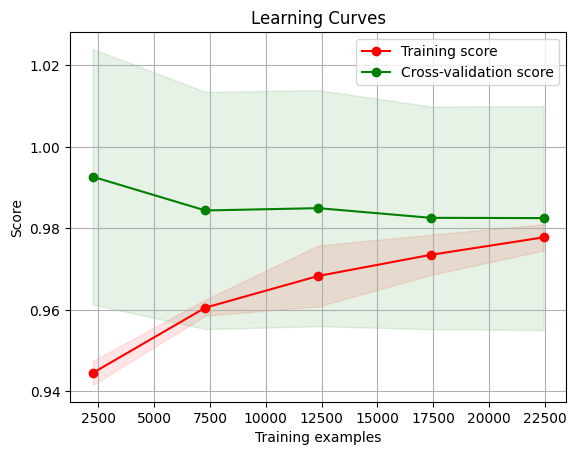

In [83]:
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=10, scoring='neg_mean_squared_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 5))

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    train_scores = np.sqrt(-train_mean)
    test_scores = np.sqrt(-test_mean)

    plt.figure()
    plt.plot(train_sizes, train_scores, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores, 'o-', color="g", label="Cross-validation score")
    plt.fill_between(train_sizes, train_scores - train_std, train_scores + train_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores - test_std, test_scores + test_std, alpha=0.1, color="g")
    plt.title('Learning Curves')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(model_gb_simplified, X_train, y_train)
